# Day2-1 RhinoCompute

## ①RhinoComputeのインストール（ローカル）
https://developer.rhino3d.com/guides/compute/development/

### 必要な環境
- Rhino7
- Visual Studio 2019以上

### インストール手順
1. [compute.rhino3d](https://github.com/mcneel/compute.rhino3d)のリポジトリをクローン
2. src¥compute.slnをVisual Studio 2019で開き「ビルド」→「ソリューションのビルド」
3. src¥bin¥Debug¥compute.geometry¥compute.geometry.exeを開く
4. 下記のように表示されればOK
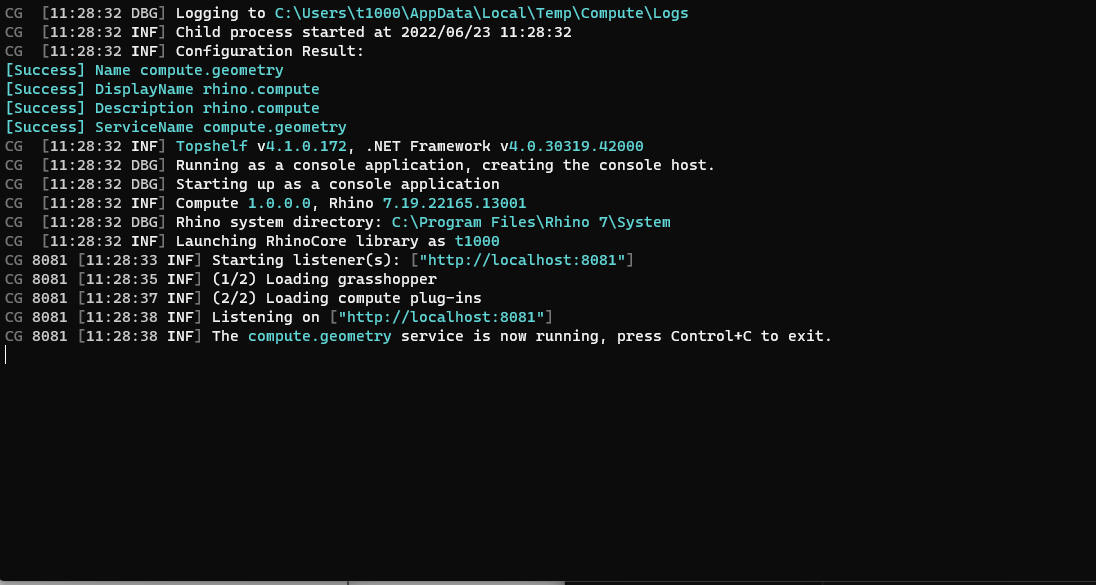

## ②Python環境にcompute.rhino3dライブラリをインストール
- この講義では0.12.2を使います
- rhino3dm, requests等も同時にインストールされていることを確認してください

In [4]:
!pip install compute-rhino3d==0.12.2

In [29]:
import compute_rhino3d.Util
import compute_rhino3d.Grasshopper as gh
import compute_rhino3d
import rhino3dm
import requests
import base64
import json
import os, io

# 本番環境で使う場合はRHINO_COMPUTE_KEYが必要ですが、今回はローカルなので不要です。
RHINO_COMPUTE_KEY = ""
RHINO_COMPUTE_HEADER = {'RhinoComputeKey': RHINO_COMPUTE_KEY}

## ③rhinocomputeサーバーとの疎通確認
- healthcheckというエンドポイントでrhinocomputeが正常に動作しているか確認できます
- 'healty'と返ってくればOKです

In [23]:
url = "http://localhost:8081/"


# http://localhost:8081/healthcheck宛にgetリクエストを送る
res = requests.get(url+"healthcheck", headers=RHINO_COMPUTE_HEADER)

# レスポンスをテキスト化
res.text

'healthy'

## ④rhinocompute用のghデータを作る
- AとBを足し算するだけのサンプルファイル「RhinoCompute_Sample.gh」を作成します

### Input
1. 入力値は「Get~」コンポーネントを使う
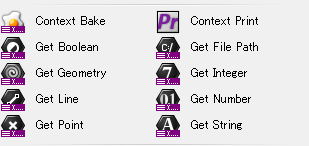
2. 入力値の名前をユニークなものに変更
3. コンポーネントを右クリックして入力されるデータの最大最小、数値であれば最大値最小値を指定
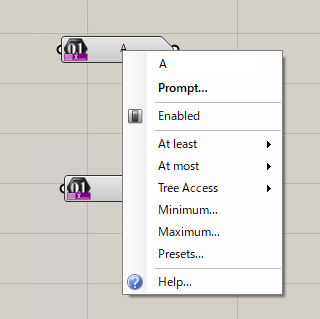
4. デフォルト値を繋いでおくと動作確認に便利です
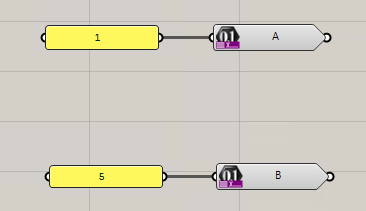

### Output
1. 出力値はグループ化する
2. 「RH_OUT:任意の名前」にする
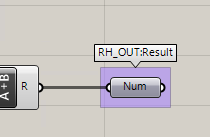

## ⑤ghファイルをRhinoComputeサーバーにアップロードする
- /ioエンドポイントへghファイルをポストしてghファイルの情報を取得します。

### ghファイルをエンコードする
- compute_rhino3dのライブラリを使えば不要ですが、ioを使うために実装します

In [24]:
# ghまたはghxファイルをbase64にエンコードします
def encode_gh_file(definition):
    encoded = None
    if os.path.isfile(definition):
        if(definition.endswith('gh')):
            with open(definition, 'rb') as gh:
                content_bytes = gh.read()
                encoded = base64.b64encode(content_bytes)
        else:
            with io.open(definition, 'r', encoding='utf-8-sig') as ghx:
                definition = ghx.read()
    if not encoded:
        encoded = base64.b64encode(definition.encode('utf-8'))
    return str(encoded, 'utf-8')

In [25]:
filepath = "./gh/RhinoCompute_Sample.gh"

encoded = encode_gh_file(filepath)

### /ioエンドポイントへポスト
- algoにエンコードした文字列を入れます
- absolutetolerance, angletolerance: それぞれ値・角度の許容値です
- cachesolveはキャッシュを使うかどうか

In [27]:
res = requests.post(url=url+"io",json=
    {
        "absolutetolerance": 0.01,
        "angletolerance": 0.01,
        "algo": encoded,
        "pointer": None,
        "cachesolve": False,
        "recursionlevel": 0,
        "values": [],
        "warnings": [],
        "errors": []
    },
    headers=RHINO_COMPUTE_HEADER
)

# レスポンスがうまくいくとstatus_codeに200が返ってきます
if res.status_code == 200:
    print("Success")
    cachekey = res.json()["CacheKey"]
    print("CacheKey: {}".format(cachekey))
else:
    print("Error")
    print(res.text)

Success
CacheKey: md5_281C02AE45C924EF21DDDF9604B6420C


In [28]:
res.json()

{'Description': '',
 'CacheKey': 'md5_281C02AE45C924EF21DDDF9604B6420C',
 'InputNames': ['A', 'B'],
 'OutputNames': ['RH_OUT:Result'],
 'Icon': None,
 'Inputs': [{'Description': '',
   'AtLeast': 1,
   'AtMost': 1,
   'Default': '1',
   'Minimum': None,
   'Maximum': None,
   'Name': 'A',
   'Nickname': None,
   'ParamType': 'Number'},
  {'Description': '',
   'AtLeast': 1,
   'AtMost': 1,
   'Default': '5',
   'Minimum': None,
   'Maximum': None,
   'Name': 'B',
   'Nickname': None,
   'ParamType': 'Number'}],
 'Outputs': [{'Name': 'RH_OUT:Result',
   'Nickname': None,
   'ParamType': 'Number'}],
 'Warnings': [],
 'Errors': []}

## ⑥ghファイルを計算させる(compute_rhino3dライブラリを使う場合)

In [32]:
# urlとapiKey(ローカルでは不要)を設定
compute_rhino3d.Util.url = url
compute_rhino3d.Util.apiKey = RHINO_COMPUTE_KEY

filepath = "./gh/RhinoCompute_Sample.gh"

# ツリーを格納するリストを作成
trees = []
# A用のツリー
paramA = gh.DataTree("A")
## [ツリー名], 値
paramA.Append([0],[5])

# B用のツリー
paramB = gh.DataTree("B")
paramB.Append([0],[10])

trees = [paramA, paramB]

# リクエストを送信
res = gh.EvaluateDefinition(filepath, trees)

res

{'absolutetolerance': 0.0,
 'angletolerance': 0.0,
 'modelunits': 'Millimeters',
 'algo': '',
 'pointer': 'md5_281C02AE45C924EF21DDDF9604B6420C',
 'cachesolve': False,
 'recursionlevel': 0,
 'values': [{'ParamName': 'RH_OUT:Result',
   'InnerTree': {'{0}': [{'type': 'System.Double', 'data': '15.0'}]}}],
 'warnings': [],
 'errors': []}

## ⑦ghファイルを計算させる(compute_rhino3dライブラリを使わない場合)
- ghファイルは先程アップロード済なのでpointerにcachekeyを指定する

In [34]:
res = requests.post(url=url+"grasshopper",json=
    {
        "absolutetolerance": 0.01,
        "angletolerance": 0.01,
        "algo": None,
        "pointer": cachekey,
        "cachesolve": False,
        "recursionlevel": 0,
        "values": [
        {
            "ParamName": "A",
            "InnerTree": { "0": [{ "type": "System.Double", "data": "5.0" }] }
        },
        {
            "ParamName": "B",
            "InnerTree": { "0": [{ "type": "System.Double", "data": "10.0" }] }
        }
        ],
        "warnings": [],
        "errors": []
    },
    headers=RHINO_COMPUTE_HEADER
)
res.json()

{'absolutetolerance': 0.0,
 'angletolerance': 0.0,
 'modelunits': 'Millimeters',
 'algo': '',
 'pointer': 'md5_281C02AE45C924EF21DDDF9604B6420C',
 'cachesolve': False,
 'recursionlevel': 0,
 'values': [{'ParamName': 'RH_OUT:Result',
   'InnerTree': {'{0}': [{'type': 'System.Double', 'data': '15.0'}]}}],
 'warnings': [],
 'errors': []}